In [1]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 51.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
import zipfile
import os
import shutil

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- CONFIGURATION ---
# Path to your zip file on Google Drive
# Make sure this matches exactly where you uploaded it!
ZIP_PATH = "/content/drive/My Drive/ptb-xl.zip"

# The fast, local destination in Colab
DEST_DIR = "/content/ptb-xl-data/"

def smart_extract(zip_path, dest_dir):
    if not os.path.exists(zip_path):
        print(f"ERROR: Could not find zip file at {zip_path}")
        print("Please check the filename and path on your Google Drive.")
        return

    print(f"Scanning {zip_path}...")

    with zipfile.ZipFile(zip_path, 'r') as z:
        all_files = z.namelist()

        # Filter: We only want files inside 'records500' or the csv
        # We verify 'records500/' is in the path AND it's not 'records100/'
        relevant_files = [
            f for f in all_files
            if ("records500/" in f or "ptbxl_database.csv" in f)
            and "records100/" not in f
            and "__MACOSX" not in f # Skip Mac metadata if present
        ]

        print(f"Found {len(all_files)} total files.")
        print(f"Extracting {len(relevant_files)} relevant files (High-Res only)...")

        # Extract only the filtered list
        z.extractall(dest_dir, members=relevant_files)

    print("Extraction complete.")

    # --- FLATTEN DIRECTORY (CRITICAL STEP) ---
    # Sometimes zips have a root folder like "ptb-xl-1.0.3/records500/..."
    # We need to ensure 'records500' is right inside 'ptb-xl-data/'

    # Find where the csv ended up
    csv_location = None
    for root, dirs, files in os.walk(dest_dir):
        if "ptbxl_database.csv" in files:
            csv_location = root
            break

    if csv_location and csv_location != dest_dir:
        print(f"Adjusting folder structure from {csv_location} to {dest_dir}...")
        # Move contents up to the main data dir
        for item in os.listdir(csv_location):
            src = os.path.join(csv_location, item)
            dst = os.path.join(dest_dir, item)
            if os.path.exists(dst): # Remove if exists to overwrite
                if os.path.isdir(dst): shutil.rmtree(dst)
                else: os.remove(dst)
            shutil.move(src, dst)
        print("Folder structure fixed.")

# Run the function
smart_extract(ZIP_PATH, DEST_DIR)
print(f"\nData is ready at: {DEST_DIR}")

Mounted at /content/drive
Scanning /content/drive/My Drive/ptb-xl.zip...
Found 87204 total files.
Extracting 43599 relevant files (High-Res only)...
Extraction complete.
Adjusting folder structure from /content/ptb-xl-data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3 to /content/ptb-xl-data/...
Folder structure fixed.

Data is ready at: /content/ptb-xl-data/


--- Using device: cuda ---

--- REAL DATA MODE ACTIVE (PTB-XL) ---
Loading metadata from /content/ptb-xl-data/ptbxl_database.csv...
Parsing diagnostic labels...
Class weights: [0.88721001 1.14564446]

Splitting training data among 3 clients...

--- STARTING EXPERIMENT FOR: Advanced (Fixed Graph LearnableAdj) ---
Model Parameters: 2,307,026
Round 1: Acc: 0.5635 | F1: 0.3604 | AUC: 0.7865
Round 2: Acc: 0.8211 | F1: 0.8191 | AUC: 0.8944
Round 3: Acc: 0.8349 | F1: 0.8338 | AUC: 0.9101
Round 4: Acc: 0.8431 | F1: 0.8421 | AUC: 0.9191
Round 5: Acc: 0.8514 | F1: 0.8506 | AUC: 0.9293
Round 6: Acc: 0.8532 | F1: 0.8526 | AUC: 0.9336
Round 7: Acc: 0.8576 | F1: 0.8569 | AUC: 0.9365
Round 8: Acc: 0.8578 | F1: 0.8574 | AUC: 0.9384
Round 9: Acc: 0.8617 | F1: 0.8611 | AUC: 0.9397
Round 10: Acc: 0.8633 | F1: 0.8628 | AUC: 0.9405

--- STARTING EXPERIMENT FOR: Baseline (ResNet1D) ---
Model Parameters: 2,179,202
Round 1: Acc: 0.7933 | F1: 0.7865 | AUC: 0.8813
Round 2: Acc: 0.8275 | F1: 0.8262 | AUC: 0.9064

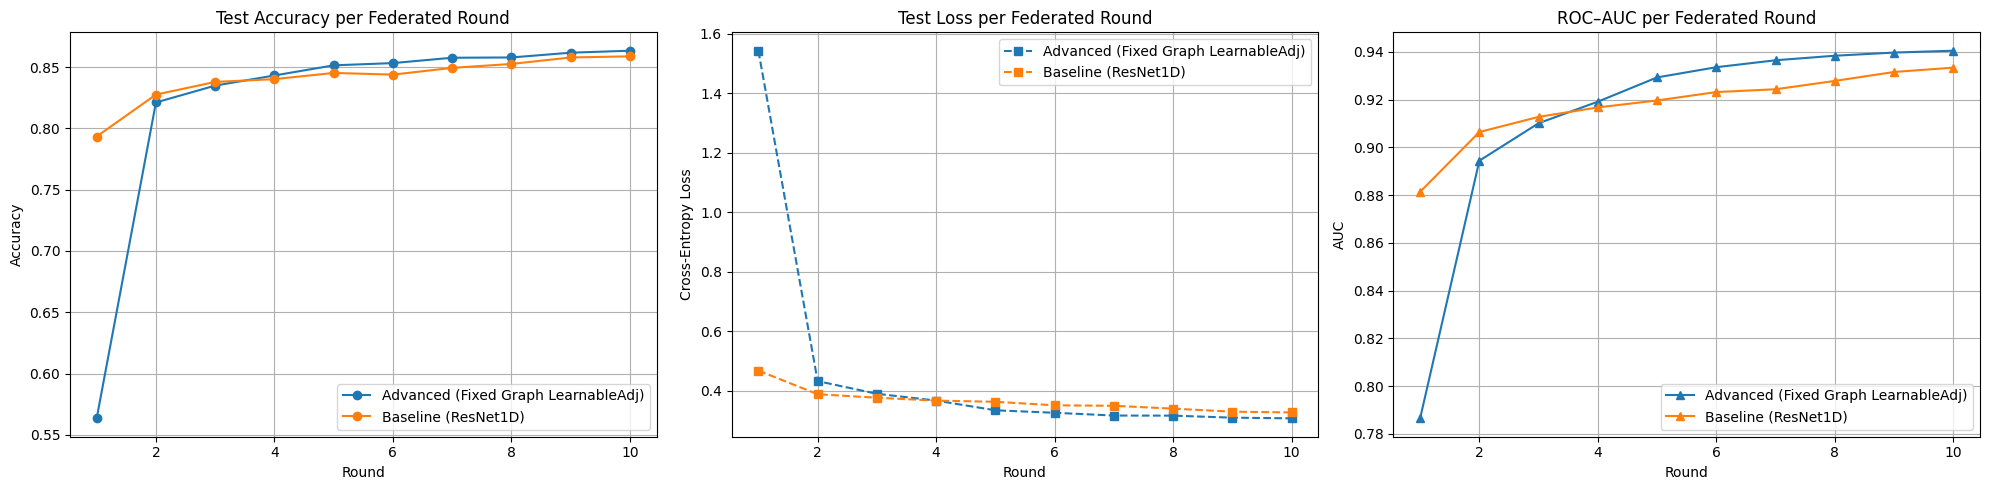

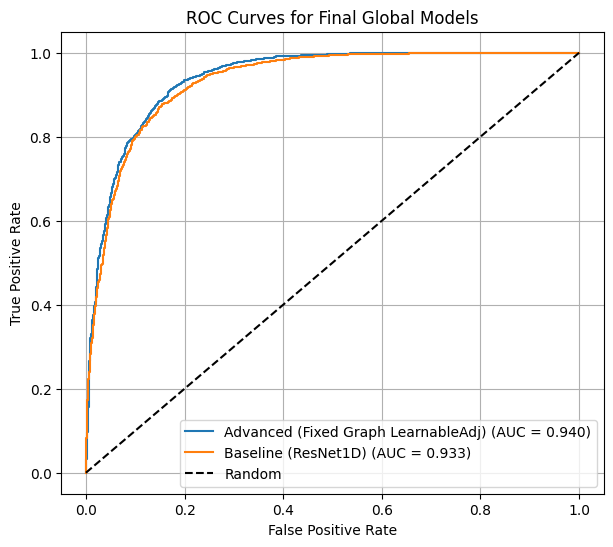

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.exceptions import DataConversionWarning
from sklearn.utils.class_weight import compute_class_weight
import warnings
import math
import time
import copy
import ast

# Try to import wfdb
try:
    import wfdb
except ImportError:
    print("Warning: 'wfdb' library not found. If you're using real PTB-XL data, install wfdb: pip install wfdb")
    wfdb = None

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

# ============================================
# --- 1. CONFIGURATION & CONSTANTS ---
# ============================================

DATA_DIR = "/content/ptb-xl-data/"
METADATA_FILE = os.path.join(DATA_DIR, "ptbxl_database.csv")

# --- Data Mode Toggles ---
SIMULATE_DATA = False
DEBUG_MODE = False
DEBUG_DATA_FRACTION = 0.05

# --- Data Constants ---
SAMPLE_RATE = 500
N_LEADS = 12
N_TIMESTEPS = 1000
TARGET_LABEL = 'is_normal'

# --- Federated Learning Constants ---
NUM_CLIENTS = 3
NUM_ROUNDS = 10
CLIENT_EPOCHS = 2
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
USE_GROUPNORM = True

# FedProx coefficient (0.0 = FedAvg behavior)
MU_PROX = 0.01

# Regularisation / optimizer
WEIGHT_DECAY = 1e-4
CLIP_NORM = 1.0
DROPOUT_PROB = 0.3

# ============================================
# --- 2. DATA PREPROCESSING & AUGMENTATION ---
# ============================================

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def augment_ecg(trace):
    """
    Apply augmentations to the ECG signal: jitter, scaling, time shift
    """
    # 1. Random Gaussian Noise (jitter)
    if np.random.rand() > 0.4:
        noise = np.random.normal(0, 0.03, trace.shape)
        trace = trace + noise

    # 2. Random Scaling (0.9x to 1.1x)
    if np.random.rand() > 0.4:
        scale = np.random.uniform(0.9, 1.1)
        trace = trace * scale

    # 3. Time shift (circular roll)
    if np.random.rand() > 0.4:
        shift = np.random.randint(-50, 50)
        trace = np.roll(trace, shift, axis=1)

    return trace

def preprocess_ecg(trace, augment=False):
    # Expected shape: [n_leads, time]
    trace = butter_bandpass_filter(trace, 0.5, 40, SAMPLE_RATE, order=5)

    for i in range(N_LEADS):
        lead = trace[i]
        if np.std(lead) > 1e-6:
            trace[i] = (lead - np.mean(lead)) / np.std(lead)
        else:
            trace[i] = lead - np.mean(lead)

    if trace.shape[1] > N_TIMESTEPS:
        start = 0
        # If augmenting, random crop!
        if augment and trace.shape[1] > N_TIMESTEPS + 100:
             start = np.random.randint(0, trace.shape[1] - N_TIMESTEPS)
        trace = trace[:, start : start + N_TIMESTEPS]
    elif trace.shape[1] < N_TIMESTEPS:
        padding = np.zeros((N_LEADS, N_TIMESTEPS - trace.shape[1]))
        trace = np.concatenate([trace, padding], axis=1)

    # Apply augmentations ONLY if training and requested
    if augment:
        trace = augment_ecg(trace)

    return trace

def time_shift(trace, max_shift=50):
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(trace, shift, axis=1)

def mixup_batch(x1, y1, x2, y2, alpha=0.2):
    """x: [B, C, T], y: [B] ints -> returns mixed x and soft labels"""
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    # convert to one-hot soft labels
    num_classes = 2
    y1_oh = F.one_hot(y1, num_classes=num_classes).float()
    y2_oh = F.one_hot(y2, num_classes=num_classes).float()
    y = lam * y1_oh + (1 - lam) * y2_oh
    return x, y

# ============================================
# --- 3. DATA LOADING / PTB-XL HELPERS ---
# ============================================

def load_ptbxl_metadata(metadata_path):
    print(f"Loading metadata from {metadata_path}...")
    if not os.path.exists(metadata_path):
        print(f"ERROR: Metadata file not found: {metadata_path}")
        return None, None, None

    df = pd.read_csv(metadata_path, index_col='ecg_id')
    print("Parsing diagnostic labels...")
    df['scp_codes'] = df['scp_codes'].apply(lambda x: ast.literal_eval(x))
    df[TARGET_LABEL] = df['scp_codes'].apply(lambda x: 1 if 'NORM' in x else 0)

    class_names = ['Abnormal', 'Normal']

    if DEBUG_MODE:
        df, _ = train_test_split(df, test_size=(1.0 - DEBUG_DATA_FRACTION), random_state=42, stratify=df[TARGET_LABEL])
        print(f"  DEBUG MODE: {len(df)} samples")

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[TARGET_LABEL])
    return train_df, test_df, class_names

def load_ptbxl_signal(record_path):
    if wfdb is None:
        return None
    try:
        signal, meta = wfdb.rdsamp(record_path)
        raw_trace = signal.T.copy()
        if meta['fs'] != SAMPLE_RATE:
            return None
        return raw_trace
    except Exception as e:
        return None

# ============================================
# --- 4. DATASET CLASSES ---
# ============================================

class PTBXLDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df.reset_index()
        self.filenames = self.df['filename_hr'].tolist()
        self.labels = self.df[TARGET_LABEL].tolist()
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        record_name = self.filenames[idx]
        record_path = os.path.join(DATA_DIR, record_name)
        raw_trace = load_ptbxl_signal(record_path)

        if raw_trace is None:
            # fallback: zeros
            raw_trace = np.zeros((N_LEADS, 5000), dtype=np.float32)

        ecg_trace = preprocess_ecg(raw_trace.astype(np.float32), augment=self.augment)
        label = self.labels[idx]

        return {
            'ecg': torch.tensor(ecg_trace.copy(), dtype=torch.float32),
            'label': torch.tensor(label, dtype=torch.long)
        }

class SimulatedECGDataset(Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        ecg_trace = torch.randn(N_LEADS, N_TIMESTEPS, dtype=torch.float32)
        label = torch.randint(0, 2, (1,), dtype=torch.long).item()
        return {'ecg': ecg_trace, 'label': label}

# ============================================
# --- 5. MODELS (ResNet backbone + GCN) ---
# ============================================

def norm_layer(planes, num_groups=4):
    if USE_GROUPNORM:
        if planes % num_groups != 0: num_groups = 2 if planes % 2 == 0 else 1
        return nn.GroupNorm(num_groups, planes)
    else:
        return nn.BatchNorm1d(planes)

class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=7, stride=stride, padding=3, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNetBackbone(nn.Module):
    def __init__(self, input_channels=1):
        super(ResNetBackbone, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=15, stride=2, padding=7, bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResidualBlock, 64, 2)
        self.layer2 = self._make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)

    def _make_layer(self, block, planes, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                norm_layer(planes)
            )
        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        return x

class ResNet1D(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet1D, self).__init__()
        self.backbone = ResNetBackbone(input_channels=N_LEADS)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.backbone(x) # [B, 256, 1]
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def init_baseline_resnet():
    return ResNet1D(num_classes=2)

# Graph layer
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, adj):
        # x: [B, N, in_features], adj: [N, N] or [B,N,N]
        support = torch.matmul(x, self.weight)  # [B,N,out]
        output = torch.matmul(adj, support)     # [B,N,out]
        return output + self.bias

class FixedGraphResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(FixedGraphResNet, self).__init__()

        # feature extractor applied per-lead (input_channels=1)
        self.feature_extractor = ResNetBackbone(input_channels=1)

        # prior adjacency (physiological)
        adj = torch.eye(N_LEADS)
        # limb group 0:6
        adj[0:6, 0:6] = 1.0
        # chest group 6:12
        adj[6:12, 6:12] = 1.0
        adj = adj + torch.eye(N_LEADS)  # boost self connections
        self.register_buffer('adj_prior', adj)

        # learnable adjacency logits
        self.adj_logits = nn.Parameter(torch.randn(N_LEADS, N_LEADS) * 0.01)

        # Graph conv layers
        self.gc1 = GraphConvolution(256, 256)
        self.gc2 = GraphConvolution(256, 256)
        self.bn_gc1 = nn.GroupNorm(8, 256)
        self.bn_gc2 = nn.GroupNorm(8, 256)
        self.dropout = nn.Dropout(DROPOUT_PROB)

        # classifier
        self.fc = nn.Linear(N_LEADS * 256, num_classes)

    def forward(self, x):
        # x: [B, N_leads, T]
        B, N, T = x.size()
        x = x.view(B * N, 1, T)
        x = self.feature_extractor(x) # [B*N, 256, 1]
        x = x.view(B, N, 256)         # [B, N, 256]

        # build adjacency: softplus ensures positivity, add prior, row-normalize
        adj_learn = F.softplus(self.adj_logits) + self.adj_prior
        adj = adj_learn / (adj_learn.sum(dim=1, keepdim=True) + 1e-8)  # [N,N]

        # graph conv 1
        g1 = self.gc1(x, adj)
        g1 = F.relu(self.bn_gc1(g1.transpose(1,2)).transpose(1,2))
        g1 = self.dropout(g1)

        # graph conv 2
        g2 = self.gc2(g1, adj)
        g2 = F.relu(self.bn_gc2(g2.transpose(1,2)).transpose(1,2))
        g2 = self.dropout(g2)

        # residual add
        x = x + g2

        x = x.view(B, -1)
        x = self.fc(x)
        return x

def init_fixed_graph_model():
    return FixedGraphResNet(num_classes=2)

# ============================================
# --- 6. FL LOGIC: client update, server agg, eval ---
# ============================================

def client_update(model, dataloader, criterion, device, global_state=None, mu=0.0, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, clip_norm=CLIP_NORM):
    """
    Trains local model. If global_state provided and mu>0, uses FedProx proximal term.
    Returns: model.state_dict()
    """
    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # scheduler per client (optional)
    total_steps = max(1, CLIENT_EPOCHS * len(dataloader))
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-6)

    # store global params for prox term if provided
    if mu > 0.0 and global_state is not None:
        global_params = {k: v.detach().clone().to(device) for k, v in global_state.items()}
    else:
        global_params = None

    for epoch in range(CLIENT_EPOCHS):
        for batch in dataloader:
            ecg = batch['ecg'].to(device)           # [B, N, T]
            labels = batch['label'].to(device)      # [B]
            optimizer.zero_grad()
            logits = model(ecg)
            loss = criterion(logits, labels)

            # FedProx proximal term
            if mu > 0.0 and global_params is not None:
                prox_reg = 0.0
                for name, param in model.state_dict().items():
                    prox_reg += torch.sum((param.to(device) - global_params[name]) ** 2)
                loss = loss + (mu / 2.0) * prox_reg

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()
            scheduler.step()

    return model.state_dict()

def server_aggregate(global_model, client_weights_list, client_sizes):
    """
    Weighted average aggregation by client dataset size.
    client_weights_list: list of state_dicts
    client_sizes: list of ints (same order)
    """
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.zeros_like(global_dict[k])

    total = float(sum(client_sizes))
    for client_weights, size in zip(client_weights_list, client_sizes):
        w = size / total
        for k in global_dict.keys():
            global_dict[k] += client_weights[k] * w

    global_model.load_state_dict(global_dict)

def evaluate_global_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            ecg = batch['ecg'].to(device)
            labels = batch['label'].to(device)

            logits = model(ecg)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = F.softmax(logits, dim=1)       # [B, 2]
            preds = torch.argmax(probs, dim=1)     # [B]

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            # for binary classification, store probability of class 1
            all_probs.extend(probs[:, 1].cpu().numpy())

    avg_loss = total_loss / max(1, len(dataloader))
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    # ROC–AUC (binary case)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        # edge case: only one class present in predictions
        auc = float('nan')

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1': f1,
        'auc': auc,
        'y_true': np.array(all_labels),
        'y_score': np.array(all_probs)
    }

def plot_results(history):
    print("\nGenerating visualization plots...")

    # --- 1) Accuracy, Loss, AUC vs rounds in one figure ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Accuracy
    ax1 = axes[0]
    for model_name, metrics in history.items():
        rounds = range(1, len(metrics['acc_history']) + 1)
        ax1.plot(rounds, metrics['acc_history'], marker='o', label=model_name)
    ax1.set_title('Test Accuracy per Federated Round')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True)
    ax1.legend()

    # Loss
    ax2 = axes[1]
    for model_name, metrics in history.items():
        rounds = range(1, len(metrics['loss_history']) + 1)
        ax2.plot(rounds, metrics['loss_history'], marker='s', linestyle='--', label=model_name)
    ax2.set_title('Test Loss per Federated Round')
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Cross-Entropy Loss')
    ax2.grid(True)
    ax2.legend()

    # AUC
    ax3 = axes[2]
    for model_name, metrics in history.items():
        rounds = range(1, len(metrics['auc_history']) + 1)
        ax3.plot(rounds, metrics['auc_history'], marker='^', label=model_name)
    ax3.set_title('ROC–AUC per Federated Round')
    ax3.set_xlabel('Round')
    ax3.set_ylabel('AUC')
    ax3.grid(True)
    ax3.legend()

    plt.tight_layout()
    plt.show()

    # --- 2) ROC curves for final models ---
    plt.figure(figsize=(7, 6))
    for model_name, metrics in history.items():
        if metrics["roc_data"] is not None:
            fpr, tpr, auc_val = metrics["roc_data"]
            plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_val:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Final Global Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# ============================================
# --- 7. MAIN TRAINING / FEDERATED LOOP ---
# ============================================

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Using device: {device} ---")

    if SIMULATE_DATA:
        train_dataset = SimulatedECGDataset(600)
        test_dataset = SimulatedECGDataset(100)
        class_weights = None
    else:
        print("\n--- REAL DATA MODE ACTIVE (PTB-XL) ---")
        train_df, test_df, loaded_class_names = load_ptbxl_metadata(METADATA_FILE)
        if train_df is None:
            print("No metadata available; aborting.")
            return

        # compute class weights for loss function
        try:
            train_labels = train_df[TARGET_LABEL].values
            cw = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
            class_weights = torch.tensor(cw, dtype=torch.float32).to(device)
            print("Class weights:", cw)
        except Exception as e:
            class_weights = None

        train_dataset = PTBXLDataset(train_df, augment=True)
        test_dataset = PTBXLDataset(test_df, augment=False)

    # Split training data among clients (contiguous shards for non-iid sim)
    print(f"\nSplitting training data among {NUM_CLIENTS} clients...")
    num_train = len(train_dataset)
    split_size = num_train // NUM_CLIENTS
    indices = list(range(num_train))
    client_dataloaders = []
    client_sizes = []
    for i in range(NUM_CLIENTS):
        start = i * split_size
        end = (i + 1) * split_size if i < NUM_CLIENTS - 1 else num_train
        client_subset = Subset(train_dataset, indices[start:end])
        client_sizes.append(len(client_subset))
        client_dataloaders.append(DataLoader(client_subset, batch_size=BATCH_SIZE, shuffle=True))

    pin_mem = (device.type == 'cuda')
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin_mem)

    # criterion with optional class weights
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()

    models_to_compare = {
        "Advanced (Fixed Graph LearnableAdj)": init_fixed_graph_model,
        "Baseline (ResNet1D)": init_baseline_resnet
    }
    experiment_history = {}

    for model_name, model_init_func in models_to_compare.items():
        print(f"\n=================================================")
        print(f"--- STARTING EXPERIMENT FOR: {model_name} ---")
        print(f"=================================================")
        global_model = model_init_func().to(device)
        print(f"Model Parameters: {sum(p.numel() for p in global_model.parameters() if p.requires_grad):,}")

        experiment_history[model_name] = {
        "acc_history": [],
        "f1_history": [],
        "loss_history": [],
        "auc_history": [],
        "roc_data": None   # (fpr, tpr, auc) for final round
        }


        for round_idx in range(NUM_ROUNDS):
            client_weights_list = []

            # each client trains locally starting from current global model
            for i in range(NUM_CLIENTS):
                local_model = copy.deepcopy(global_model).to(device)
                # pass global_state and mu for FedProx
                global_state = copy.deepcopy(global_model.state_dict())
                local_weights = client_update(
                    local_model,
                    client_dataloaders[i],
                    criterion,
                    device,
                    global_state=global_state,
                    mu=MU_PROX,
                    lr=LEARNING_RATE,
                    weight_decay=WEIGHT_DECAY,
                    clip_norm=CLIP_NORM
                )
                client_weights_list.append(local_weights)

            # server aggregation (weighted)
            server_aggregate(global_model, client_weights_list, client_sizes)

            # evaluate
            test_metrics = evaluate_global_model(global_model, test_loader, criterion, device)

            experiment_history[model_name]["acc_history"].append(test_metrics['accuracy'])
            experiment_history[model_name]["f1_history"].append(test_metrics['f1'])
            experiment_history[model_name]["loss_history"].append(test_metrics['loss'])
            experiment_history[model_name]["auc_history"].append(test_metrics['auc'])

            # Save ROC curve data from the FINAL round
            if round_idx == NUM_ROUNDS - 1:
                fpr, tpr, _ = roc_curve(test_metrics['y_true'], test_metrics['y_score'])
                experiment_history[model_name]["roc_data"] = (fpr, tpr, test_metrics['auc'])

            print(
                f"Round {round_idx + 1}: "
                f"Acc: {test_metrics['accuracy']:.4f} | "
                f"F1: {test_metrics['f1']:.4f} | "
                f"AUC: {test_metrics['auc']:.4f}"
            )

    plot_results(experiment_history)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("\n--- An unexpected error occurred ---")
        import traceback
        traceback.print_exc()


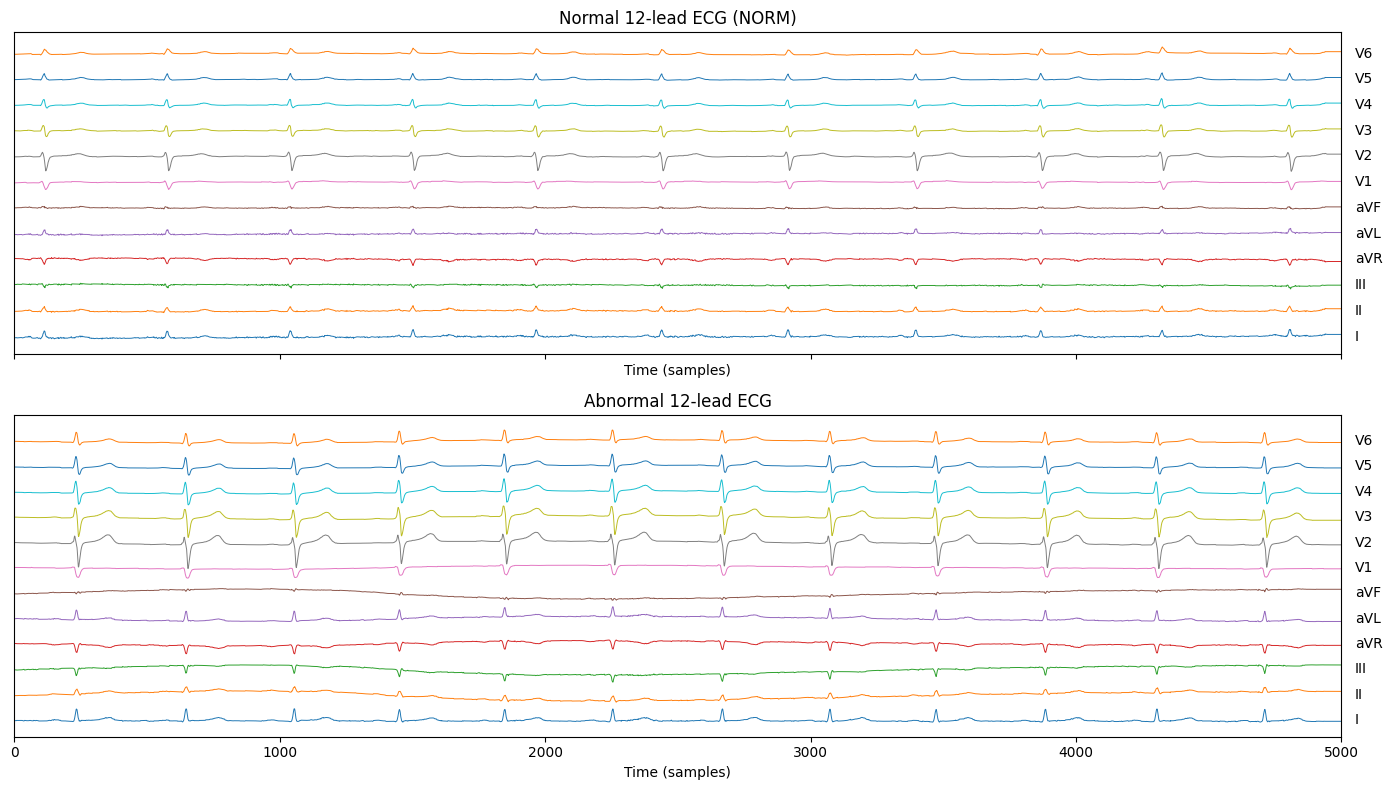

In [3]:
#GENERATING NORMAL VS ABNOMARL LEAD ECG FOR REPORT DOCUMENTATION
import os
import ast
import wfdb
import pandas as pd
import matplotlib.pyplot as plt

# --- Load PTB-XL metadata ---
metadata_path = os.path.join(DEST_DIR, "ptbxl_database.csv")
df = pd.read_csv(metadata_path)

# Parse scp_codes and create is_normal label (same logic as in your code)
df['scp_codes'] = df['scp_codes'].apply(lambda x: ast.literal_eval(x))
df['is_normal'] = df['scp_codes'].apply(lambda x: 1 if 'NORM' in x else 0)

# Pick one normal and one abnormal example
normal_row = df[df['is_normal'] == 1].iloc[0]
abnormal_row = df[df['is_normal'] == 0].iloc[0]

def load_ecg(record_rel_path):
    rec_path = os.path.join(DEST_DIR, record_rel_path)
    signal, meta = wfdb.rdsamp(rec_path)
    # signal shape: (timesteps, 12) -> transpose to (12, timesteps)
    return signal.T

normal_ecg = load_ecg(normal_row['filename_hr'])
abnormal_ecg = load_ecg(abnormal_row['filename_hr'])

leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

# --- Plot Figure 3.1 ---
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

def plot_ecg(ax, ecg, title):
    n_leads, T = ecg.shape
    offset = 0
    for i in range(n_leads):
        ax.plot(ecg[i] + offset, linewidth=0.7)
        ax.text(T * 1.01, offset, leads[i], va='center')
        offset += 2.5  # vertical spacing between leads
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xlim(0, T)
    ax.set_xlabel("Time (samples)")

plot_ecg(axes[0], normal_ecg, "Normal 12-lead ECG (NORM)")
plot_ecg(axes[1], abnormal_ecg, "Abnormal 12-lead ECG")

plt.tight_layout()
plt.savefig("Figure_3_1_Normal_vs_Abnormal_ECG.png", dpi=300)
plt.show()
